# Manga Generator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil

In [ ]:

import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/manga_data/archive.zip", 'r') as zip_ref:
    zip_ref.extractall("archive")

In [ ]:
if not os.path.exists('archive1'):
    os.makedirs('archive1')

if not os.path.exists('/content/archive1/MANGA'):
    os.makedirs('/content/archive1/MANGA')

if not os.path.exists('archive2'):
    os.makedirs('archive2')

if not os.path.exists('/content/archive2/PHOTOS'):
    os.makedirs('/content/archive2/PHOTOS')


In [ ]:
def move_files(source_dir, destination_dir):
    # Get a list of all files in the source directory
    files = os.listdir(source_dir)

    # Move each file from the source directory to the destination directory
    for file in files:
        source_file = os.path.join(source_dir, file)
        destination_file = os.path.join(destination_dir, file)
        shutil.move(source_file, destination_file)



In [ ]:
move_files('/content/archive/MANGA', '/content/archive1/MANGA')
move_files('/content/archive/photos', '/content/archive2/PHOTOS')

In [ ]:
img_size = (1024, 1024)

manga_data = tf.keras.utils.image_dataset_from_directory("/content/archive1", image_size=img_size, color_mode='grayscale')
manga_data_iterator = manga_data.as_numpy_iterator()

Found 31771 files belonging to 1 classes.


In [ ]:
manga_batch = manga_data_iterator.next()

In [ ]:
photo_data = tf.keras.utils.image_dataset_from_directory("archive2", image_size=img_size, color_mode='grayscale')
photo_data_iterator = photo_data.as_numpy_iterator()

Found 31783 files belonging to 1 classes.


In [ ]:
photo_batch = photo_data_iterator.next()

## Preprocess

In [ ]:
# normalizing the photos and manga data
manga_data = manga_data.map(lambda x,y: (x/255, y))
photo_data = photo_data.map(lambda x,y: (x/255, y))

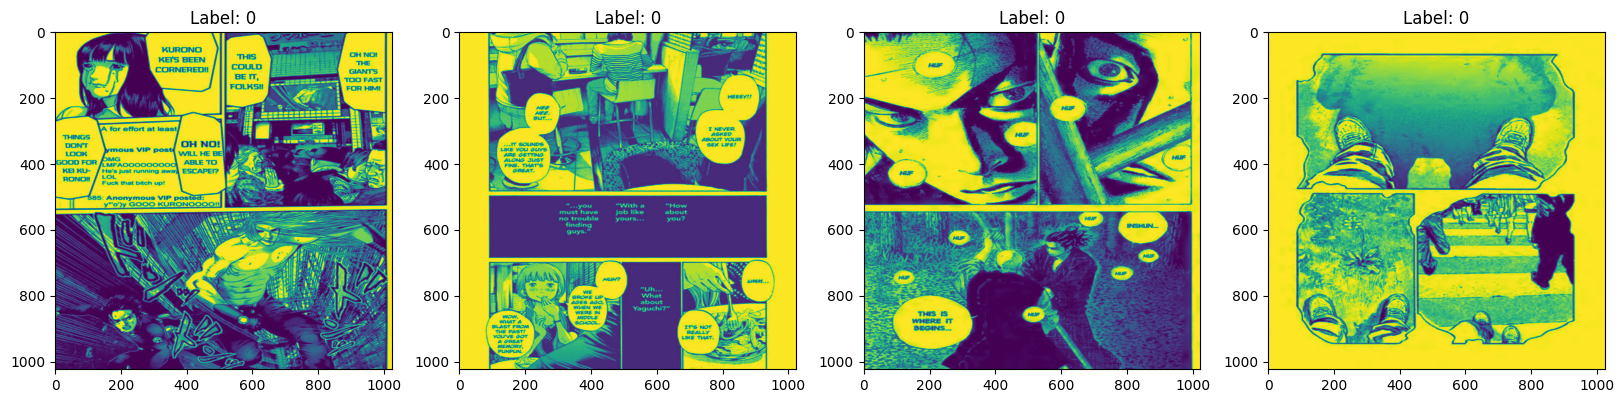

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(manga_batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(f"Label: {manga_batch[1][idx]}")

## Discriminator

In [ ]:
def make_discriminator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(16, (3, 3), strides=(2, 2), padding='same', input_shape=[1024, 1024, 1]))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Conv2D(16, (3, 3), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [ ]:
D = make_discriminator()
D.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 512, 512, 16)      160       
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 512, 512, 16)      0         
                                                                 
 dropout_2 (Dropout)         (None, 512, 512, 16)      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 16)      2320      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 256, 256, 16)      0         
                                                                 
 dropout_3 (Dropout)         (None, 256, 256, 16)      0         
                                                                 
 flatten_1 (Flatten)         (None, 1048576)          

In [ ]:
def make_generator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(16 * 256 * 256, input_dim=100))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Reshape((256, 256, 16)))
    model.add(tf.keras.layers.Conv2DTranspose(16, (4, 4), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Conv2DTranspose(16, (4, 4), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

    return model

In [ ]:
G = make_generator()
G.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1048576)           105906176 
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 1048576)           0         
                                                                 
 reshape_2 (Reshape)         (None, 256, 256, 16)      0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 512, 512, 16)     4112      
 ranspose)                                                       
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 512, 512, 16)      0         
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 1024, 1024, 16)   4112      
 ranspose)                                            

In [ ]:
def define_gan(generator, discriminator):
    discriminator.trainable = False
    model = tf.keras.Sequential()
    model.add(generator)
    model.add(discriminator)
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [ ]:
def generate_real_samples(dataset, n_samples):
    ix = np.random.randint(0, dataset[0].shape[0], n_samples)
    X = dataset[0]
    y = np.ones((n_samples, 1))
    return X, y
    # return 1, 0

def generate_latent_points(latent_dim, n_samples):
    x_input = np.random.randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

def generate_fake_samples(generator, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = generator.predict(x_input)
    y = np.zeros((n_samples, 1))

    # save the image
    for i in range(n_samples):
        plt.imsave(f"/content/drive/MyDrive/manga_data/generated/{i}.png", X[i].reshape(1024, 1024), cmap='gray')

    return X, y

In [ ]:
# create a line plot of loss for the gan
def plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist):
    # plot loss
    plt.subplot(2, 1, 1)
    plt.plot(d1_hist, label='d-real')
    plt.plot(d2_hist, label='d-fake')
    plt.plot(g_hist, label='gen')
    plt.legend()
    # plot discriminator accuracy
    plt.subplot(2, 1, 2)
    plt.plot(a1_hist, label='acc-real')
    plt.plot(a2_hist, label='acc-fake')
    plt.legend()
    # save plot to file
    plt.savefig('/content/drive/MyDrive/manga_data/generated/plot_line_plot_loss.png')
    plt.close()

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=64):
    batch_per_epoch = len(dataset)
    half_batch = int(n_batch / 2)


    d1_hist, d2_hist, g_hist, a1_hist, a2_hist = list(), list(), list(), list(), list()

    for i in range(n_epochs):
        d_acc_real, d_acc_fake = 0.0, 0.0  # Initialize accuracy variables

        for j in range(50):

            data_itr = dataset.as_numpy_iterator()

            X_real, y_real = generate_real_samples(data_itr.next(), half_batch)

            d_loss1, d_acc1 = d_model.train_on_batch(X_real, y_real)
            d_acc_real += d_acc1  # Accumulate real accuracy

            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)

            d_loss2, d_acc2 = d_model.train_on_batch(X_fake, y_fake)
            d_acc_fake += d_acc2  # Accumulate fake accuracy

            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))

            g_loss = gan_model.train_on_batch(X_gan, y_gan)

            d1_hist.append(d_loss1)
            d2_hist.append(d_loss2)
            g_hist.append(g_loss)
            a1_hist.append(d_acc1)
            a2_hist.append(d_acc2)

            print(f"Epoch: {i}, Batch: {j}, d_loss1: {d_loss1}, d_loss2: {d_loss2}, g_loss: {g_loss}")

        # Calculate average accuracy for real and fake samples
        d_acc_real /= batch_per_epoch
        d_acc_fake /= batch_per_epoch

        print(f"Epoch: {i}, d_acc_real: {d_acc_real}, d_acc_fake: {d_acc_fake}")

        plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist)

        # Save the generator model for every epoch
        g_model.save(f"generator_model/generator_model_{i}.h5")



In [ ]:
if not os.path.exists('generated_images'):
    os.makedirs('generated_images')

if not os.path.exists('generated_model'):
    os.makedirs('generated_model')

if not os.path.exists('results_baseline'):
    os.makedirs('results_baseline')

In [ ]:
train(G, D, define_gan(G, D), manga_data, 100, 64)

1/1 [==============================] - 0s 121ms/step
